**PERSONS INVOLVED IN THE GROUP:** ### Ziyu LIU, Clément MAGNIN, Clément RIBES, Lei WANG, Ziyuan WANG ###




**Before starting:**

You need to install Basemap. Do it only once.

In [0]:
%%bash
apt-get install libgeos-3* libgeos-dev
pip install https://github.com/matplotlib/basemap/archive/master.zip

**Goal of this practice:**

The goal is to use a cloud computing platform (the Google Cloud Platform). We will use big data tools on Colab to process large datasets. These data are real satellite observations of the ocean (5 years).

**Evaluation of this practice:**

I will evaluate 3 main components.

The first is the quality of the code. It must be concise and well written. The goal is to manipulate big data tools provided by the Google Cloud Platform (such as BigQuery).

The second is the quality of the outputs. Never forget that you are dealing with physical variables evolving in space and time. You must use maps and time series. You must also write the units (for example, °C, m).

The third thing is the discussion about your results. Again, remember that you are dealing with oceanographic data. They have a physical meaning and you should be able to comment the outputs.

**Import libraries:**

- matplotlib (2D plotting)
- pylab (scientific computing)
- basemap (plotting 2D data on maps)
- scikit-learn (machine learning)
- pandas (data structures and data analysis tools)

In [8]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(20,20) # graph size

Populating the interactive namespace from numpy and matplotlib


**Declare functions:**
- plot_im (plot satellite image with geographic coordinates)
- plot_ts (plot time series)

In [0]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='ortho',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)
    
# function to plot time series
def plot_ts(time,SST,line_type,var_name):

    # plot
    plot_date(time,SST,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

**The satellite database:**

In this practice, we use 5 years (2011-2015) of satellite observations of the global ocean. We use daily data with 25km spatial resolution. We study the Sea Surface Temperature (SST, in degrees) and the Sea Surface Height (SSH, in meters). SST and SSH are indexed in space (lon, lat) and time. The full database is stored in csv files and is quite large (~50Go).

**Part 1) Manipulation of a small dataset using pandas:**

We start to work on a small database (only the 10 first days in 2015, ~250Mo) and we will perform some basic statistics. The idea is to show that even if you use a small sample, basic data manipulation without big data tools is difficult, time and resource consuming.

After copying the dataset "data_sst_ssh_2015_small.csv" on your Colab environment, we read it using pandas (easy-to-use data structures and data analysis tools). We use the *groupby* and *mean* pandas functions to: map the global SST and SSH (using *plot_im*), plot the mean SST and SSH time series (using *plot_ts*).

In [0]:
# read dataframe
data = pd.read_csv('data_sst_ssh_2015_small.csv', header=None, names=['lat', 'lon', 'sst', 'time', 'ssh'])

In [0]:
# sample of the dataset
data

lat      lon  sst      time     ssh
0       -77.625  322.625 -1.8  735600.0 -1.2535
1       -77.375  319.625 -1.8  735600.0 -1.2179
2       -77.375  319.875 -1.8  735600.0 -1.2214
3       -77.375  320.125 -1.8  735600.0 -1.2247
4       -77.375  320.375 -1.8  735600.0 -1.2285
...         ...      ...  ...       ...     ...
5338138  81.875   29.375 -1.8  735609.0 -0.3426
5338139  81.875   29.625 -1.8  735609.0 -0.3394
5338140  81.875   29.875 -1.8  735609.0 -0.3377
5338141  81.875   30.125 -1.8  735609.0 -0.3370
5338142  81.875   30.375 -1.8  735609.0     NaN

[5338143 rows x 5 columns]

In [0]:
# statistics of the dataset
data.describe()

lat           lon           sst          time           ssh
count  5.338143e+06  5.338143e+06  5.338143e+06  5.338143e+06  5.338142e+06
mean  -1.140247e+01  1.932643e+02  1.646710e+01  7.356045e+05  3.436659e-01
std    3.845651e+01  1.003294e+02  1.041889e+01  2.871929e+00  7.254869e-01
min   -7.762500e+01  1.250000e-01 -1.800000e+00  7.356000e+05 -1.520300e+00
25%   -4.462500e+01  1.123750e+02  6.450000e+00  7.356020e+05 -3.170000e-02
50%   -1.587500e+01  1.971250e+02  1.950000e+01  7.356050e+05  5.697000e-01
75%    1.737500e+01  2.733750e+02  2.595000e+01  7.356070e+05  8.530000e-01
max    8.437500e+01  3.598750e+02  3.345000e+01  7.356090e+05  1.898000e+00

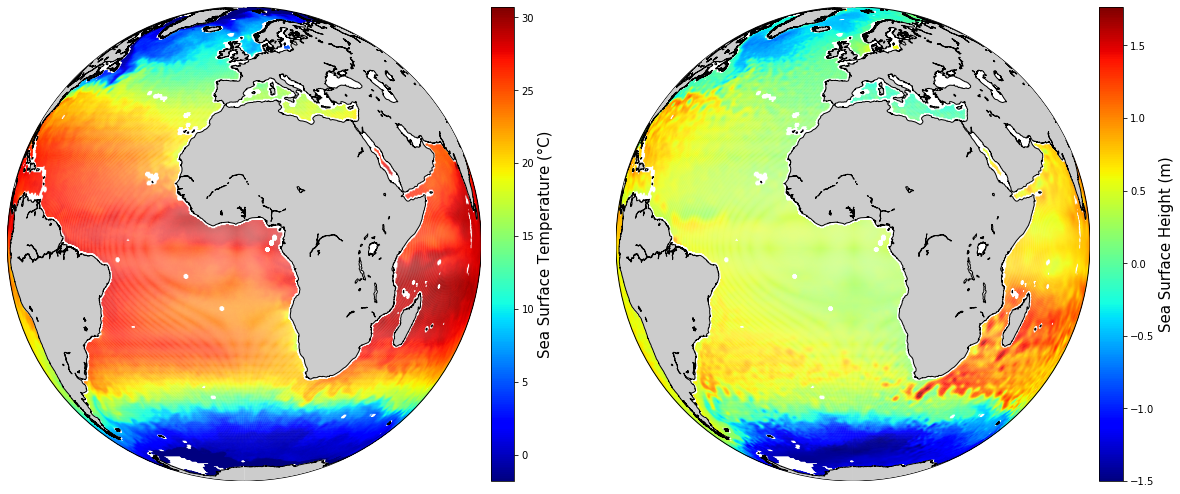

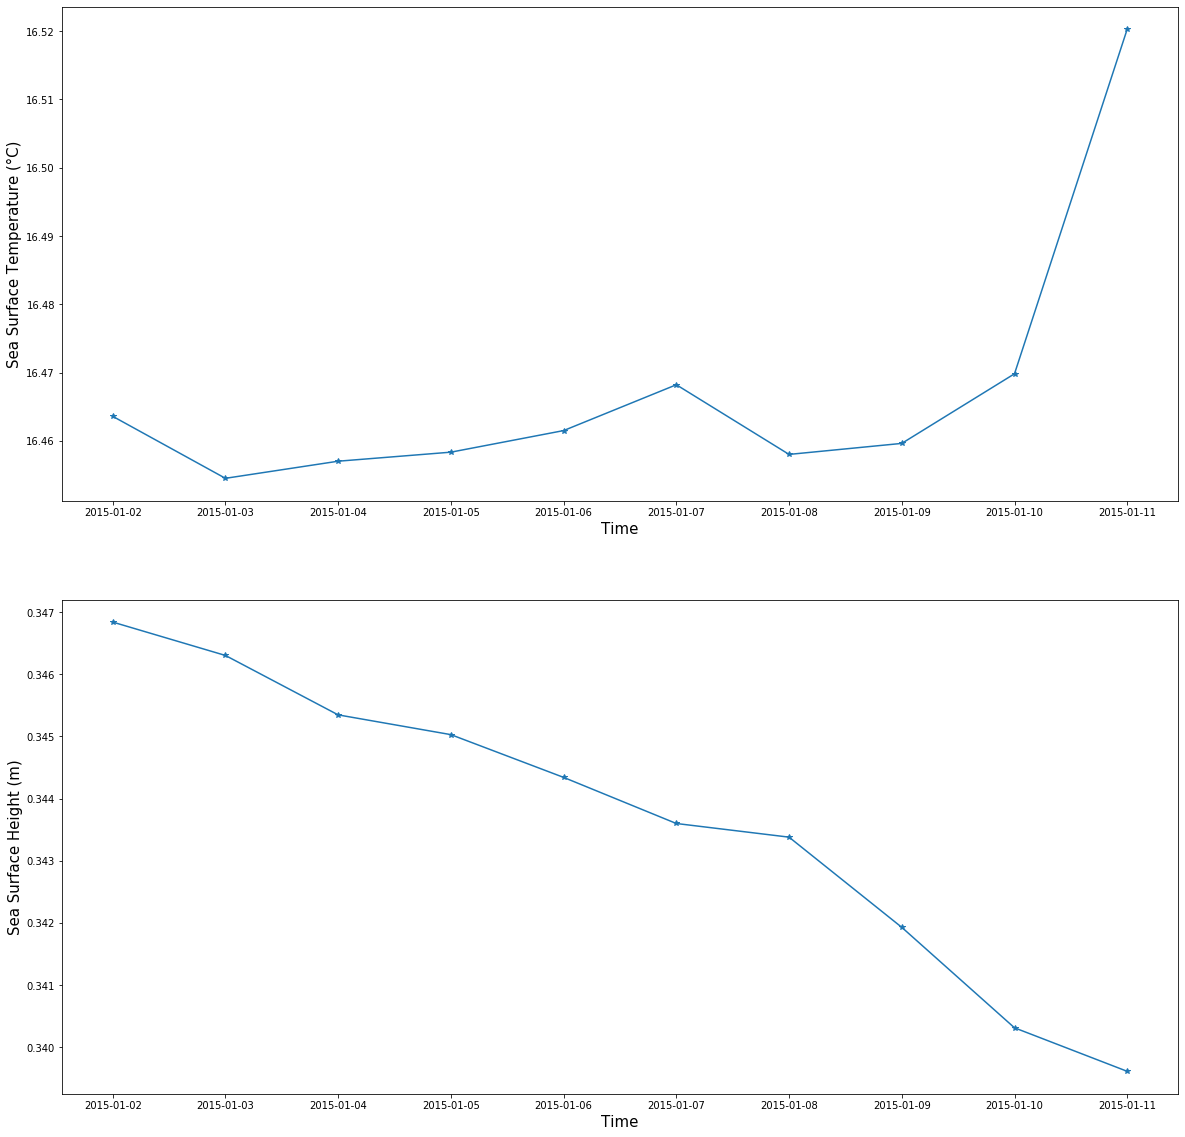

In [0]:
# plot global SST and SSH maps
sst_im=data.groupby(['lon','lat'])['sst'].mean()
ssh_im=data.groupby(['lon','lat'])['ssh'].mean()
lon_im=data.groupby(['lon','lat'])['lon'].mean()
lat_im=data.groupby(['lon','lat'])['lat'].mean()
figure()
subplot(1,2,1)
plot_im(lon_im,lat_im,sst_im,1,'Sea Surface Temperature (°C)')
subplot(1,2,2)
plot_im(lon_im,lat_im,ssh_im,1,'Sea Surface Height (m)')

# plot global SST and SSH time series
sst_ts=data.groupby(['time'])['sst'].mean()
ssh_ts=data.groupby(['time'])['ssh'].mean()
time_ts=data.groupby(['time'])['time'].mean()
figure()
subplot(2,1,1)
plot_ts(time_ts,sst_ts,'-*','Sea Surface Temperature (°C)')
subplot(2,1,2)
plot_ts(time_ts,ssh_ts,'-*','Sea Surface Height (m)')

Now, we consider only a small region of the Globe: the Mediterranean Sea. As previously, we plot the mean time series and maps of SST and SSH. We also plot the SSH as a function of SST and the 2 distributions using histograms.

Text(0, 0.5, 'Sea Surface Height (m)')

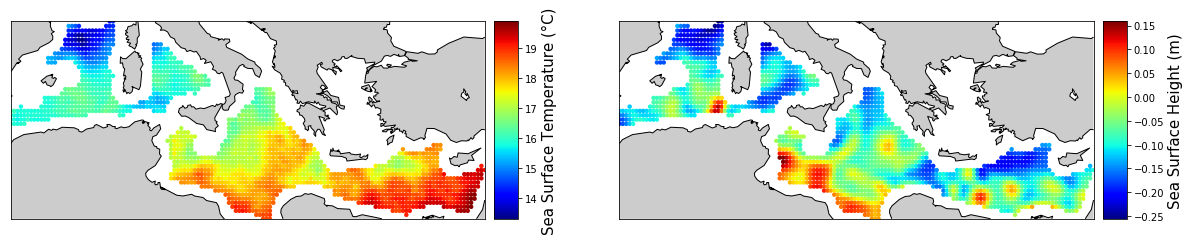

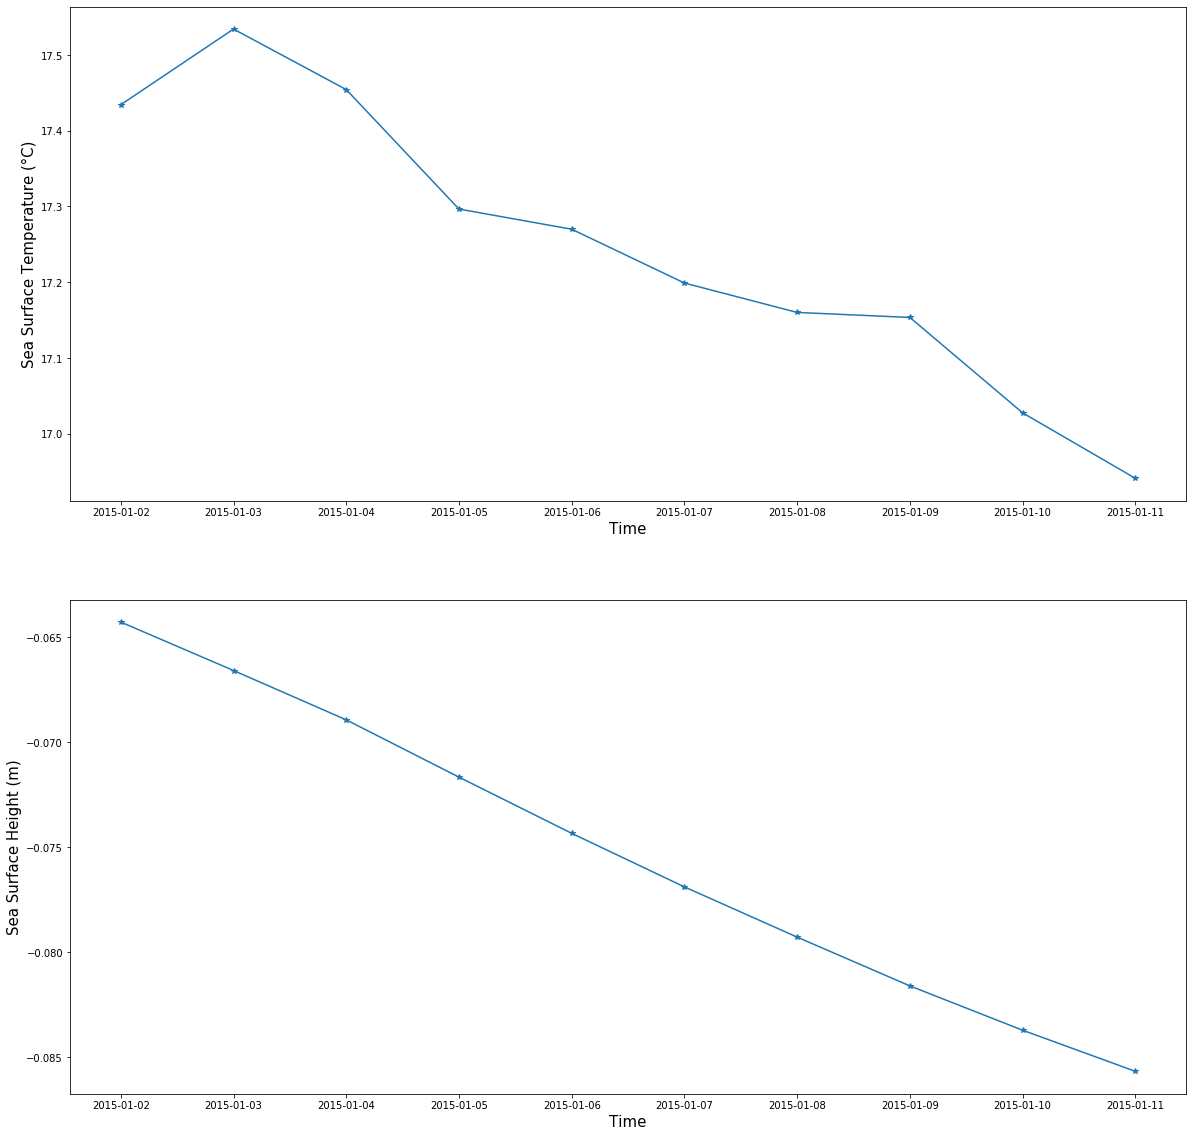

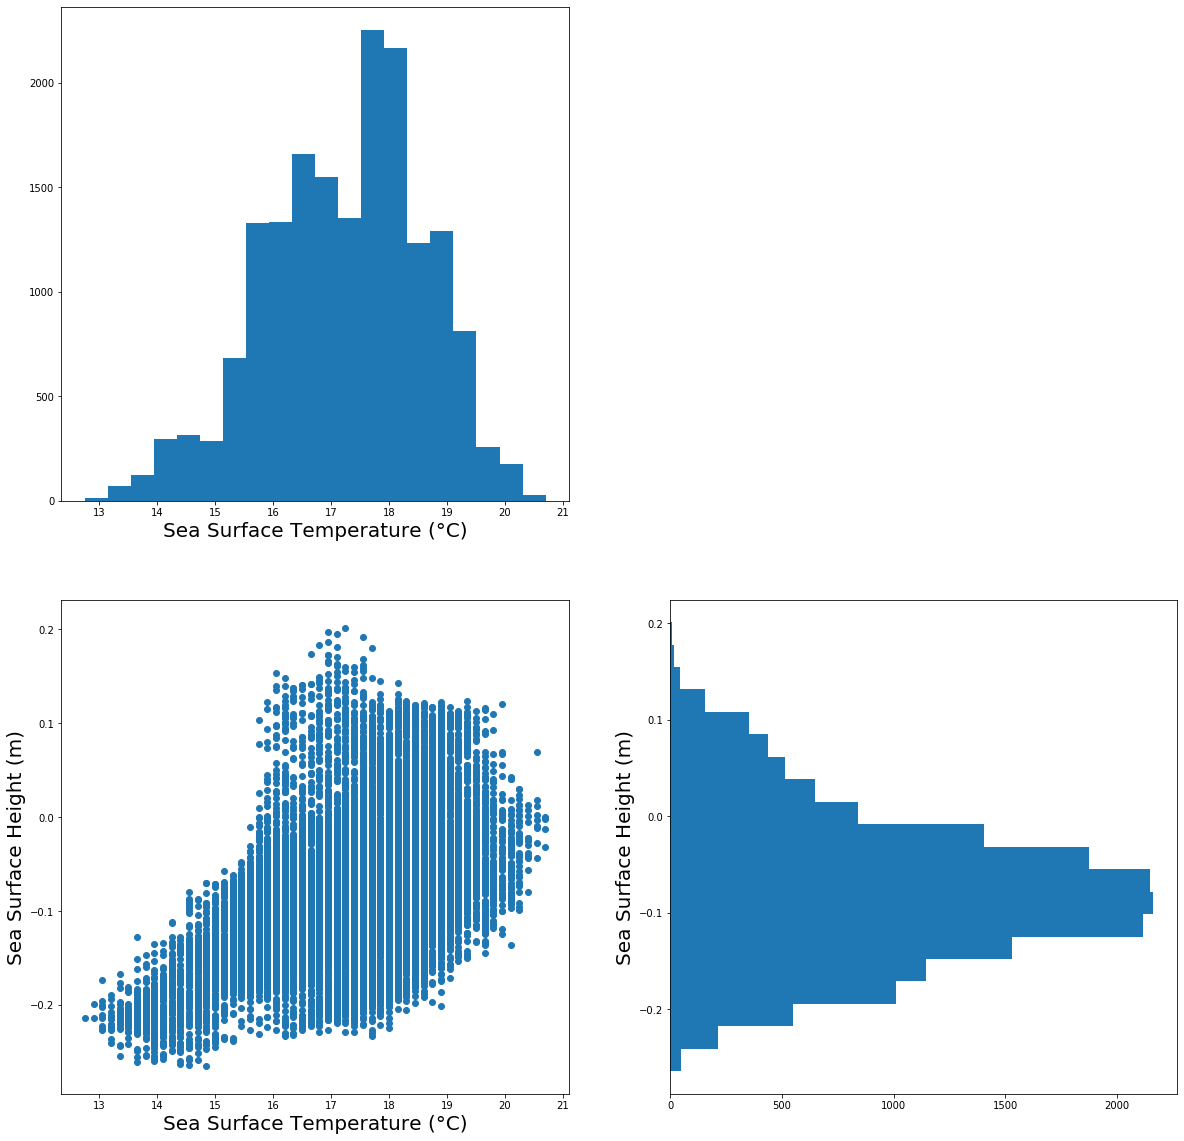

In [0]:
#@title 
# data selection
data_med=data[(data.lon>0) & (data.lon<35) & (data.lat>30) & (data.lat<45)]

# plot SST and SSH maps
sst_med_im=data_med.groupby(['lon','lat'])['sst'].mean()
ssh_med_im=data_med.groupby(['lon','lat'])['ssh'].mean()
lon_med_im=data_med.groupby(['lon','lat'])['lon'].mean()
lat_med_im=data_med.groupby(['lon','lat'])['lat'].mean()
figure()
subplot(1,2,1)
plot_im(lon_med_im,lat_med_im,sst_med_im,20,'Sea Surface Temperature (°C)')
subplot(1,2,2)
plot_im(lon_med_im,lat_med_im,ssh_med_im,20,'Sea Surface Height (m)')

# plot SST and SSH time series
sst_med_ts=data_med.groupby(['time'])['sst'].mean()
ssh_med_ts=data_med.groupby(['time'])['ssh'].mean()
time_med_ts=data_med.groupby(['time'])['time'].mean()
figure()
subplot(2,1,1)
plot_ts(time_med_ts,sst_med_ts,'-*','Sea Surface Temperature (°C)')
subplot(2,1,2)
plot_ts(time_med_ts,ssh_med_ts,'-*','Sea Surface Height (m)')

# plot hist(SST), hist(SSH), SSH~SST
figure()
subplot(2,2,1)
hist(data_med.sst, 20)
xlabel('Sea Surface Temperature (°C)', size=20)
subplot(2,2,4)
hist(data_med.ssh, 20, orientation=u'horizontal')
ylabel('Sea Surface Height (m)', size=20)
subplot(2,2,3)
scatter(data_med.sst, data_med.ssh)
xlabel('Sea Surface Temperature (°C)', size=20)
ylabel('Sea Surface Height (m)', size=20)

**Remark:**

The dataset used above is small (250Mo) and corresponds only to 10 days. Now, we want to manipulate the full database of 5 years (50Go) using big data tools. This database is stored in the Google Cloud Platform.

**Part 2) Manipulation of the full database using BigQuery**

First, we have to connect to the Google Cloud Platform. using the following command. You will have to enter the login "bigdataocean2020@gmail.com" and password "bdoimt2020_mce". Do it only once.



In [0]:
from google.colab import auth
auth.authenticate_user()

The Google Cloud Platform has set up a tool to handle large databases. This is called "BigQuery" and it is based on the NoSQL ("Not only SQL") language. The syntax in BigQuery is very similar to the pandas example given in Part 1). For instance, in the example below, we plot the mean SST map in the Mediterranean Sea over the period 2011-2015. The full 5-years dataset is stored in the BigQuery table *bdo2020.bdo2020.2011_2015*. The project is called *alert-ground-261008* (strange but you have to provide it). The result of the BigQuery request is stored in the *output* dataframe. 

In [0]:
%%bigquery --project alert-ground-261008 output
SELECT lon, lat, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.2011_2015
WHERE lon>0 AND lon<35 AND lat>30 AND lat<45
GROUP BY lon, lat

In [0]:
# sample of the dataframe
output

lon     lat   mean_sst
0     16.875  32.125  22.570975
1     17.875  32.125  22.326424
2     27.125  32.375  22.462048
3     30.625  32.375  22.674644
4     31.375  32.375  22.910980
...      ...     ...        ...
1718   6.625  41.375  18.573549
1719  11.625  41.375  19.689759
1720   6.875  42.125  18.264677
1721   6.125  42.375  17.866429
1722   4.375  42.625  17.653176

[1723 rows x 3 columns]

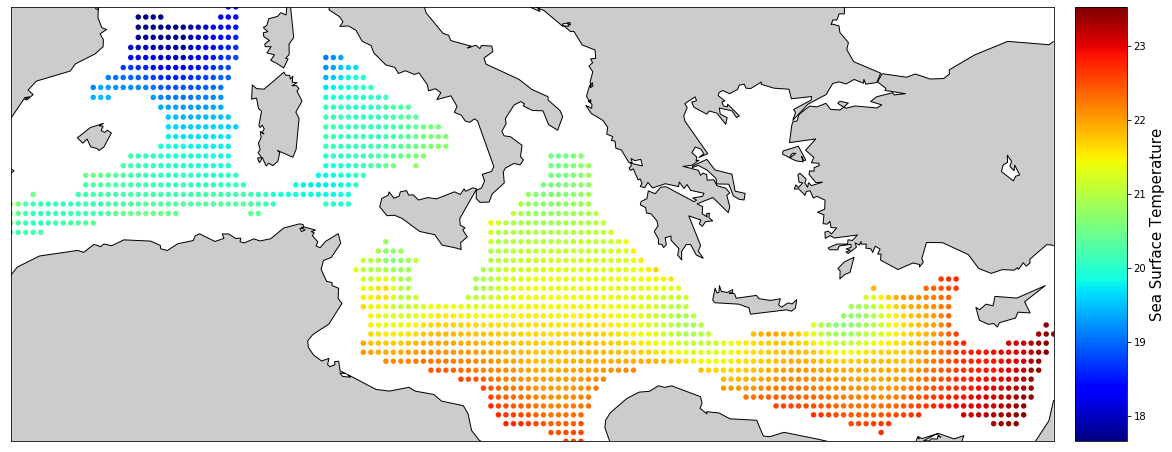

In [0]:
plot_im(output.lon,output.lat,output.mean_sst,30,'Sea Surface Temperature')

SQL language is suitable to manipulate and compute basic statistics such as the mean, standard deviation, minimum, maximum, correlation, etc... Here you will find the list of basic functions: https://cloud.google.com/bigquery/docs/reference/legacy-sql?hl=fr.

**QUESTION 1**: Compute and plot the correlation map over the period 2011-2015 between SST and SSH in the Agulhas current, between longitudes (+15,+70) and latitudes (-50,-30).

In [0]:
### TO DO ###
%%bigquery --project alert-ground-261008 output
SELECT lon, lat, CORR(sst,ssh) AS corre
FROM bdo2020.bdo2020.2011_2015
WHERE lon>15 AND lon<70 AND lat>-50 AND lat<-30
GROUP BY lon, lat

#plot_im(output.lon,output.lat,output.mean_sst,30,'Sea Surface Temperature')


In [0]:
output

lon     lat      corr
0      15.375 -38.375  0.210980
1      17.875 -38.375  0.192452
2      21.375 -38.375  0.098906
3      28.625 -38.375  0.431691
4      32.125 -38.375  0.457563
...       ...     ...       ...
16463  57.375 -38.625  0.247277
16464  58.375 -38.625  0.277428
16465  62.875 -38.625  0.362328
16466  63.375 -38.625  0.393549
16467  67.875 -38.625  0.211359

[16468 rows x 3 columns]

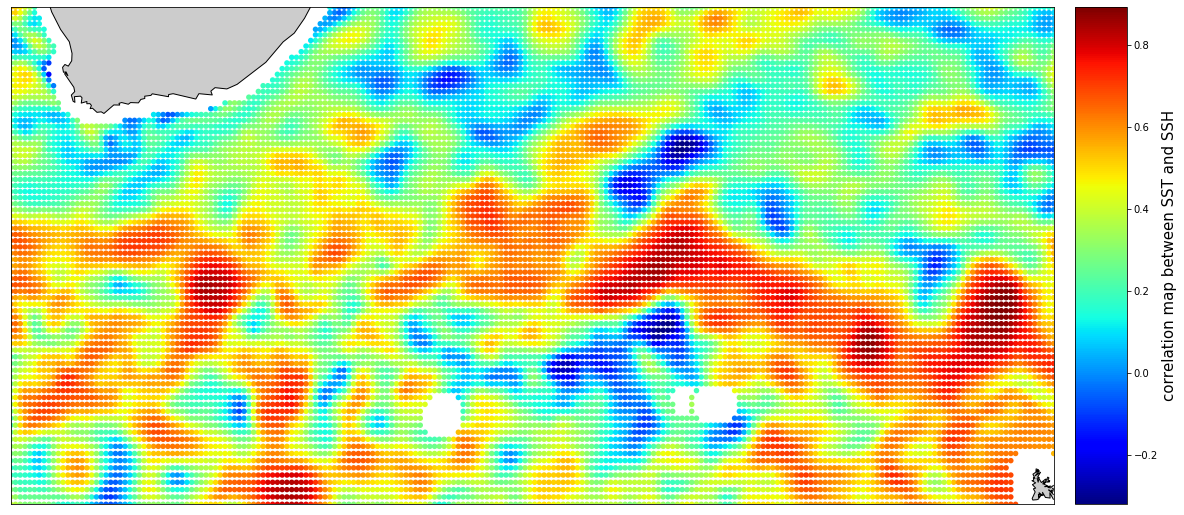

In [0]:
plot_im(output.lon,output.lat,output.corre,30,'correlation map between SST and SSH')

We can see that SST and SSH are much more correlated (correlation sometimes reaching 0.8 in the middle of the sea than near the coasts (correlation close to 0).

**QUESTION 2**: Plot the dealy mean and standard deviation time series of SST for the period 2011-2015 in the Equatorial Pacific, between longitudes (+180,+300) and latitudes (-20,+20). The mean SST time series is called the ENSO index and is used to identify El Nino and La Nina events.

In [0]:
### TO DO ###

%%bigquery --project alert-ground-261008 output
SELECT time ,
AVG(sst)  AS mean_sst , 
STDDEV(sst) AS std_sst  
#ORDER BY time DESC  
FROM bdo2020.bdo2020.2011_2015
WHERE lon>180 AND lon<300 AND lat>-20 AND lat<+20
GROUP BY time
ORDER BY time

In [0]:
output

Text(0.5, 0, 'Year')

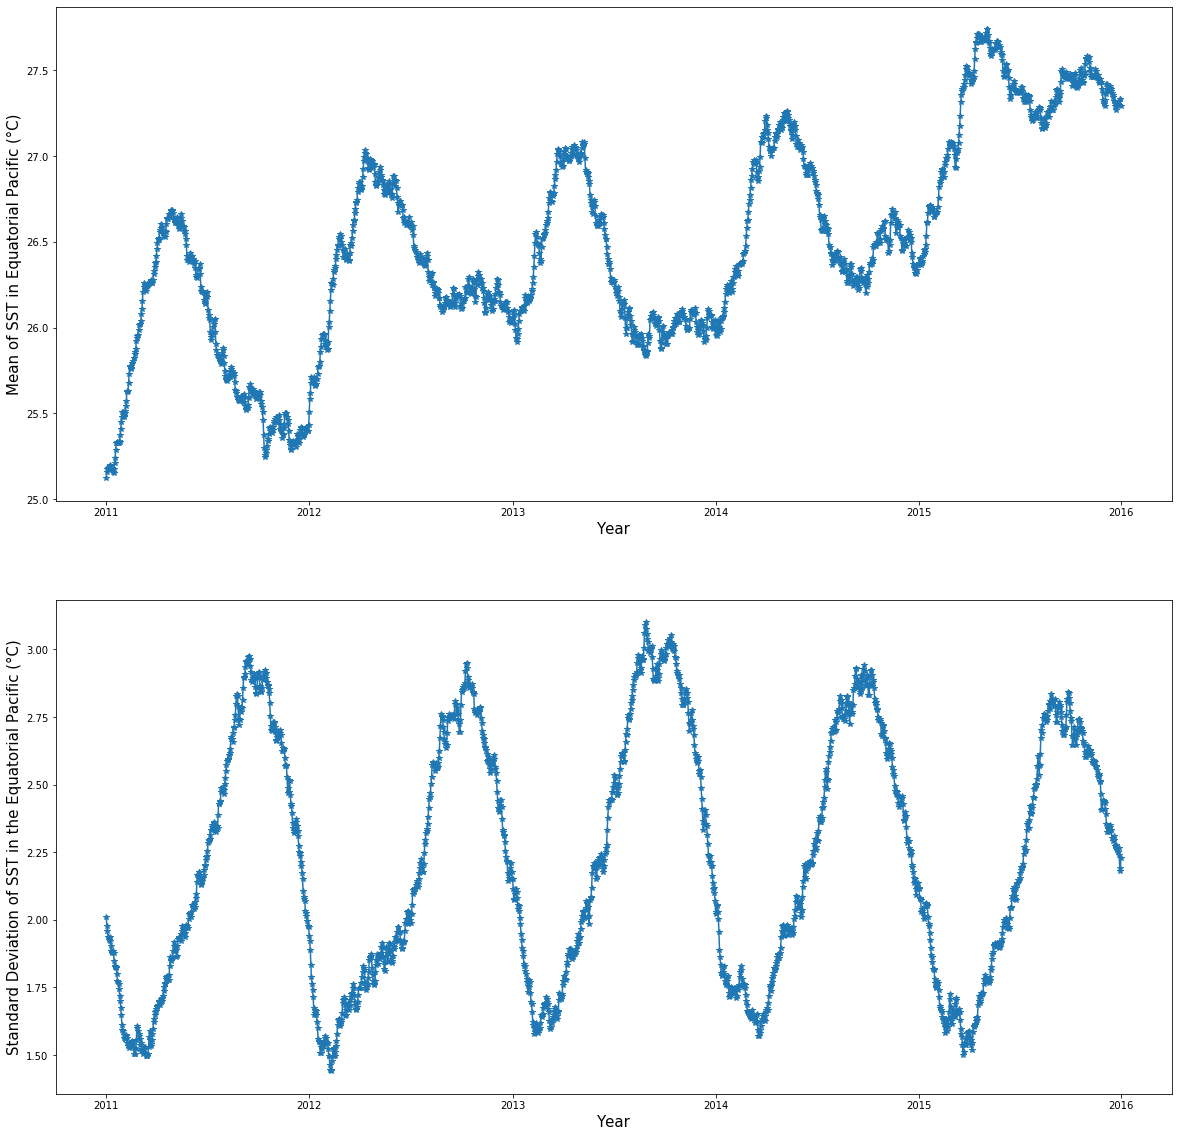

In [0]:
figure
subplot(2,1,1)
plot_ts(output.time, output.mean_sst,'-*','Mean of SST in Equatorial Pacific (°C)')
xlabel("Year")
subplot(2,1,2)
plot_ts(output.time, output.std_sst,'-*','Standard Deviation of SST in the Equatorial Pacific (°C)')
xlabel("Year")


One can observe seasonal cycles (waverings in the mean of SST) and an overall increase in the sea level in the Equatorial Pacific (SST mean curve going up from 26 °C on average in 2011 against 27.5°C on average in 2015). The homogeneity of SST in the Equatorial Pacific has also been wavering (as shown by the SST standard deviation curve, oscillating from 1,5 to 3 °C).

**QUESTION 3**: Over the years 2011-2015, compute the mean seasonal cycle of the SST and SSH in the Red Sea, between longitudes (+32,+45) and latitudes (+13,+30). This sea is the warmest in the world.

In [0]:
### TO DO ###
%%bigquery --project alert-ground-261008 output
SELECT time, AVG(sst) AS mean_sst, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.2011_2015
WHERE lon>32 AND lon<45 AND lat>13 AND lat<30 
GROUP BY time
ORDER BY time


In [0]:
output

No handles with labels found to put in legend.
No handles with labels found to put in legend.


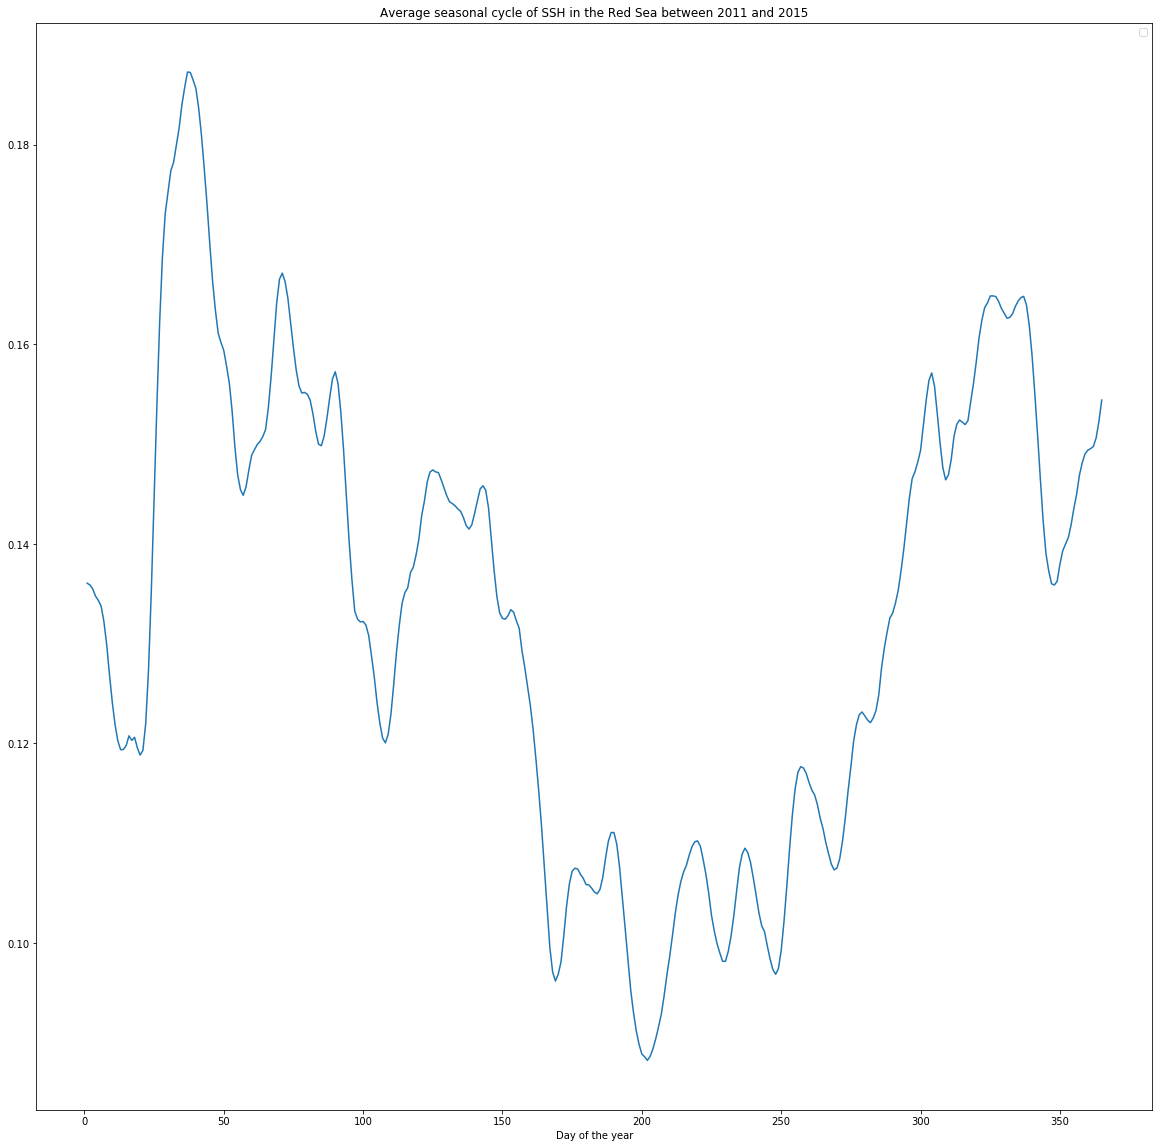

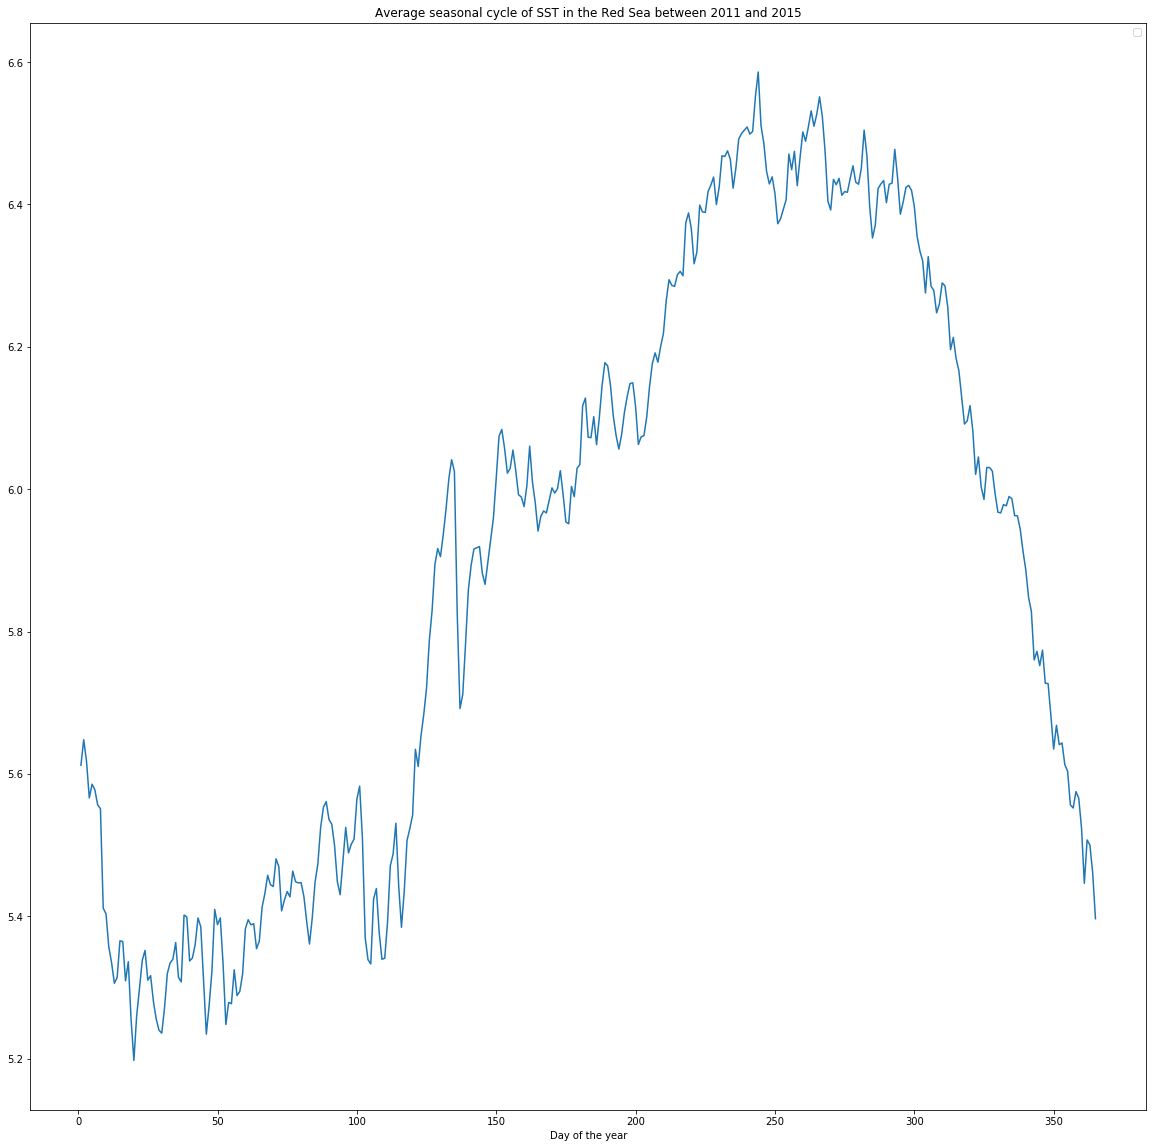

In [0]:
import numpy as np

#figure()
#n = range(1,366)
 #plot(n,output.mean_sst[0:365],label='year2011')
 #plot(n,output.mean_sst[365:365+365],label='year2012')
 #plot(n,output.mean_sst[365+366:365*3+1],label="year2013",)
 #plot(n,output.mean_sst[365*3+1:365*4+1],label="year2014")
 #plot(n,output.mean_sst[365*4+1:365*5+1],label="year2015")
 #legend()



sum1 = np.zeros(365) # we have to plot the mean over the five years
for i in range(365):
    for j in range(5):
      sum1[i] = output.mean_ssh[365*j+i]
meanssh = sum1/5
figure()
plot(n,meanssh)
title("Average seasonal cycle of SSH in the Red Sea between 2011 and 2015 (m)")
xlabel("Day of the year")
legend()


# for the SSH
sum2 = np.zeros(365) # we have to plot the mean over the five years
for i in range(365):
    for j in range(5):
      sum2[i] = output.mean_sst[365*j+i]
meansst = sum2/5
figure()
plot(n,meansst)
title("Average seasonal cycle of SST in the Red Sea between 2011 and 2015 (°C)")
xlabel("Day of the year")
legend()

The SST seams to be the highest during summer (6,6 °C) and the lowest during winter (5,2 °C) but just with a small difference. This is the other way round for the SSH: higher during winter (up to 0,18 m) against 0.08 m at least during summer.

**QUESTION 4**: Compute the dealy time series of SST over the period 2011-2015 in the Gulf of Mexico, between longitudes (+263,+281) and latitudes (+17,+35). In this region, there are a lot of hurricanes and they use the energy of the sea (hot waters) to get stronger. Thus, after a hurricane, we see a rapid decrease of the SST. Plot the time series of the difference of SST between 2 consecutive days and check that the negative peaks correspond to well known hurricanes.

In [0]:
### TO DO ###
%%bigquery --project alert-ground-261008 output
SELECT time, AVG(sst) AS mean_sst 
FROM bdo2020.bdo2020.2011_2015
WHERE lon>263 AND lon<281 AND lat>17 AND lat<35
GROUP BY time
ORDER BY time



In [0]:
output

time   mean_sst
0     734138.0  23.415692
1     734139.0  23.452813
2     734140.0  23.420637
3     734141.0  23.459802
4     734142.0  23.500879
...        ...        ...
1821  735959.0  25.903714
1822  735960.0  25.816747
1823  735961.0  25.924615
1824  735962.0  26.101780
1825  735963.0  26.190527

[1826 rows x 2 columns]

Text(0.5, 0, 'Year')

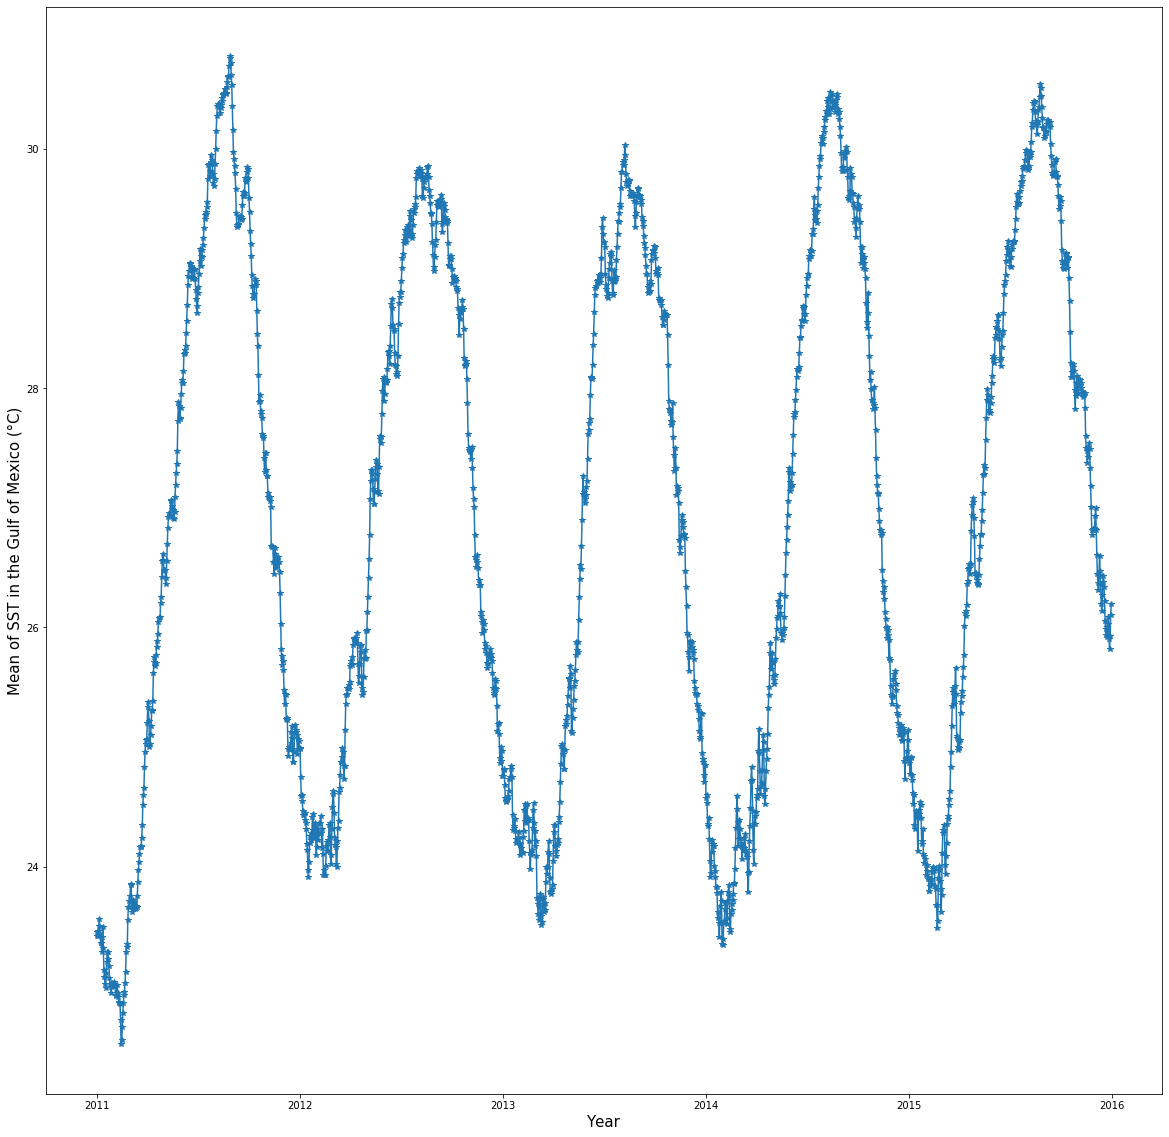

In [0]:
plot_ts(output.time,output.mean_sst,'-*','Mean of SST in the Gulf of Mexico (°C)')
xlabel("Year")

Text(0.5, 0, 'Year')

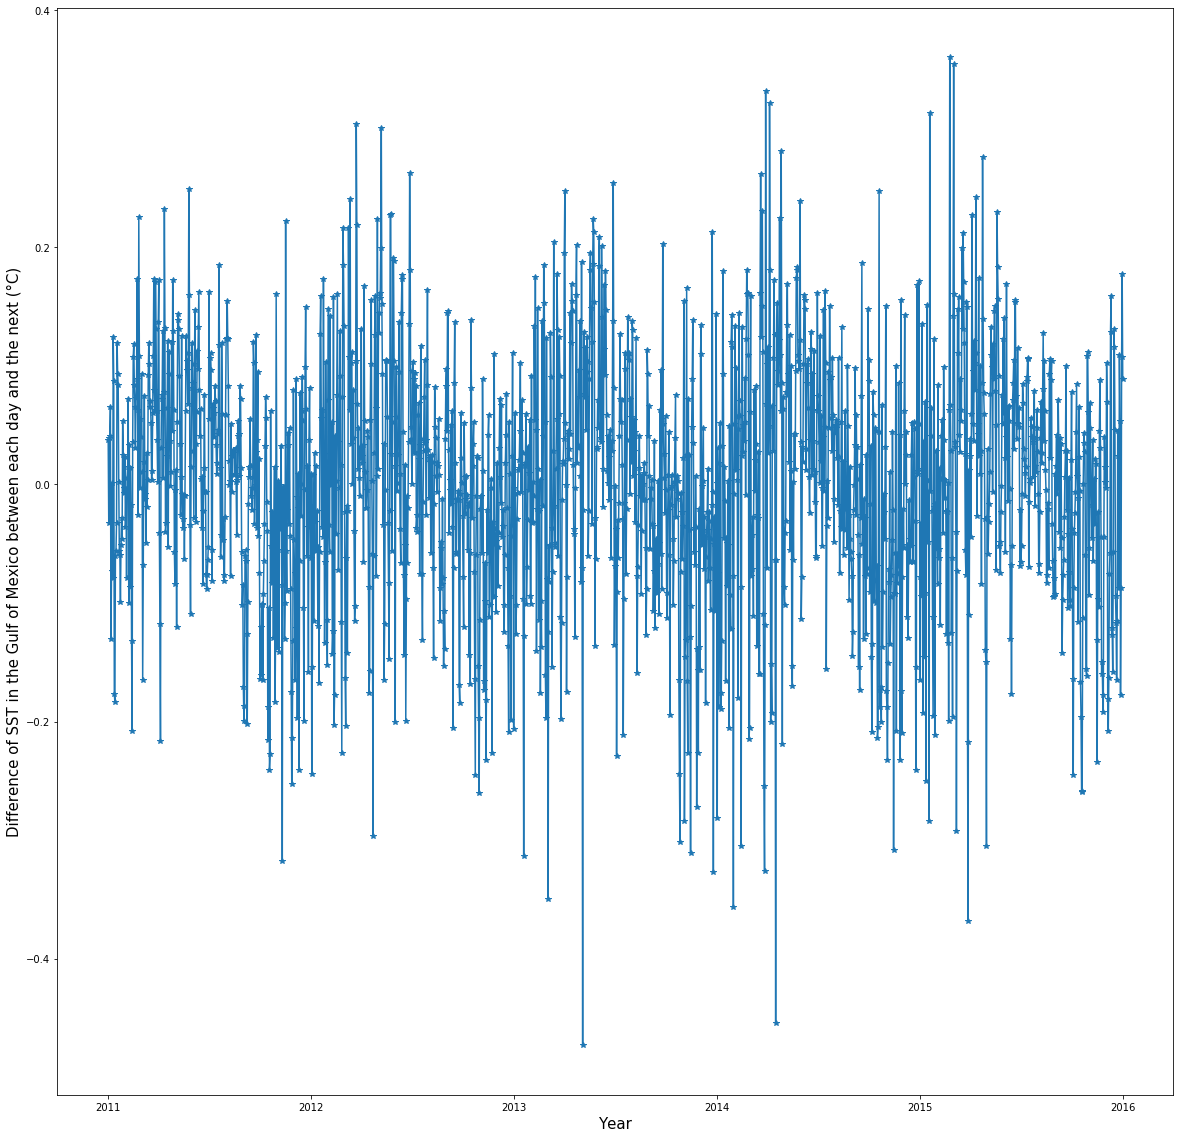

In [0]:
change = output.mean_sst.shift(1)
diff = output.mean_sst - change
plot_ts(output.time,diff,'-*','Difference of SST in the Gulf of Mexico between each day and the next (°C)') # I changed the title
xlabel("Year")

Due to the formula which has been used, the hurricanes take place when the SST difference on the graph reaches peaks with very highly negative values: like around April 2013 and around April 2014, but it does not correspond to the usual hurrican season in the Gulf of Mexico (June - November)

**Part 3) Combination of BigQuery and scikit-learn**

Now, we will extract data using BigQuery and apply regressions (using scikit-learn) on these extracted data. 

Note that there is another way to use machine learning algorithms (like the linear regression) in BigQuery, but this solution is difficult to implement: I suggest to use the classic one (i.e., using scikit-learn).

**QUESTION 5**: Model the daily mean SST in the Mediterranean Sea using a linear tendancy and a one-year seasonal cycle such that: $SST(t)=\alpha_0 + \alpha_1 t + \alpha_2 sin(2\pi\omega t) + \alpha_3 cos(2\pi\omega t)$, with $\omega=\frac{1}{365}$. Plot the corresponding observed and predicted SST time series.

In [0]:
### TO DO ###

%%bigquery --project alert-ground-261008 output
SELECT time, AVG(sst) as mean_sst
FROM bdo2020.bdo2020.2011_2015
WHERE lon>0 AND lon<35 AND lat>30 AND lat<45

GROUP BY time
ORDER BY time

In [0]:
realSST = np.array(output.mean_sst)
nbJours = len(realSST)

In [15]:
import numpy as np

A0 = np.ones((nbJours,1), dtype = float)
A1 = np.zeros((nbJours,1), dtype = float)
for i in range(nbJours):      # arange doesn't work for a 2D array
  A1[i,0] = i
A2 = np.cos((2*np.pi/365)*A1)
A3 = np.sin((2*np.pi/365)*A1)

A = np.concatenate((A0,A1,A2,A3), axis = 1)
A

array([[ 1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  9.99851839e-01,
         1.72133562e-02],
       [ 1.00000000e+00,  2.00000000e+00,  9.99407401e-01,
         3.44216116e-02],
       ...,
       [ 1.00000000e+00,  1.82300000e+03,  9.99407401e-01,
        -3.44216116e-02],
       [ 1.00000000e+00,  1.82400000e+03,  9.99851839e-01,
        -1.72133562e-02],
       [ 1.00000000e+00,  1.82500000e+03,  1.00000000e+00,
        -4.77736048e-15]])

In [0]:
from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept = False)
reg.fit(A, realSST)

arrReg = reg.coef_

Text(0.5, 0, 'Year')

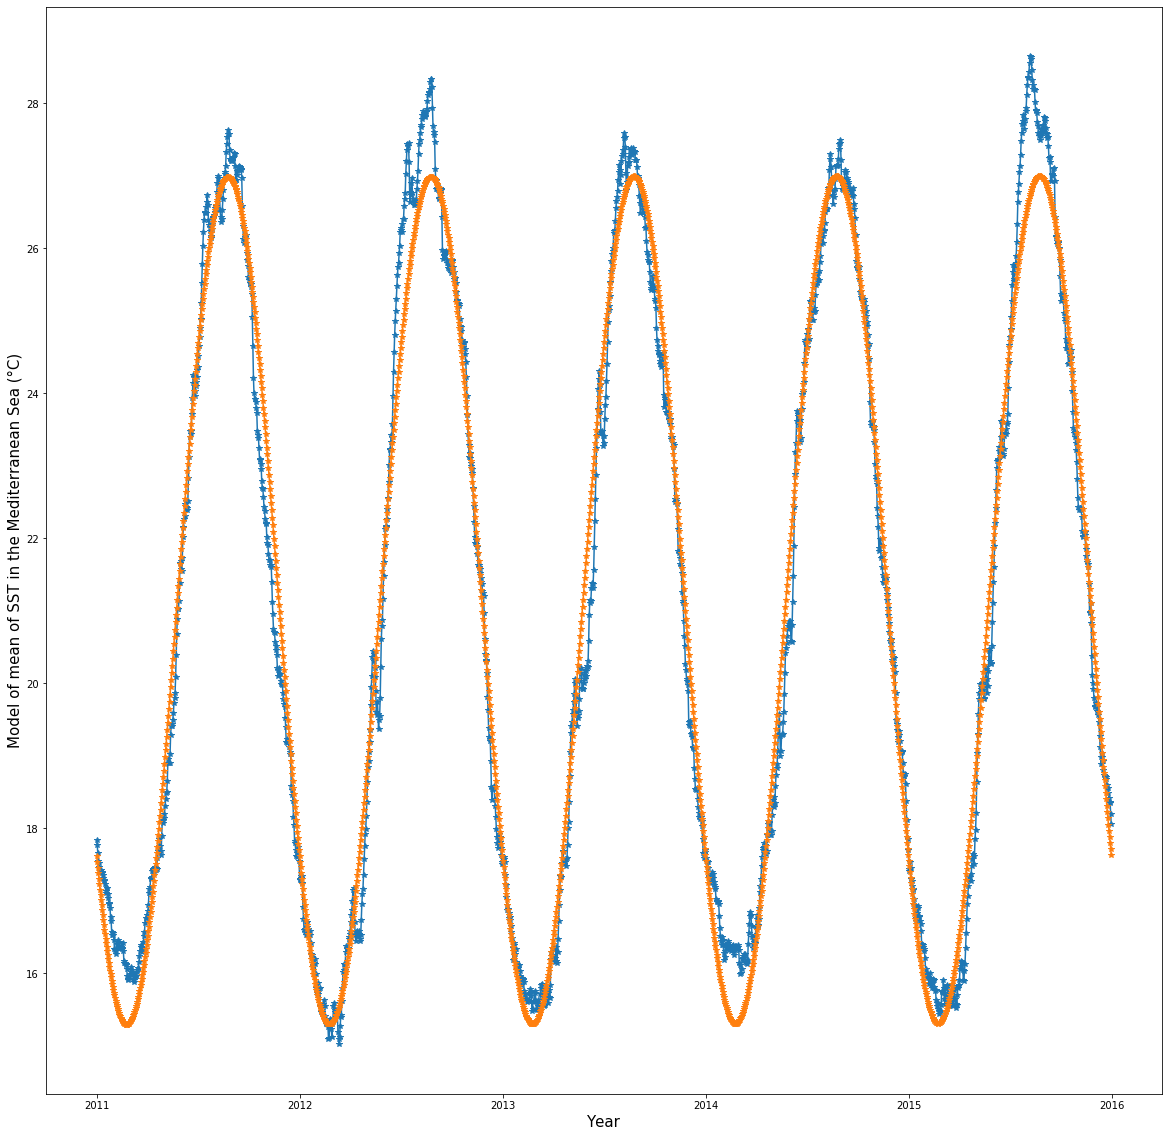

In [17]:
plot_ts(output.time,output.mean_sst,'-*','Mean of SST in the Mediterranean Sea (°C)')
xlabel("Year")
plot_ts(output.time,np.dot(A,arrReg),'-*','Model of mean of SST in the Mediterranean Sea (°C)')
xlabel("Year")

We can conclude a perfect fitting results using linear model.The SSH follows a kind of sinusoidal trend (21 °C on average with a 10°C peak-to-peak amplitude). 


**QUESTION 6**: Compute the SSH difference between the first day in 2011 and the last day in 2015, and then plot this difference at each location in the globe. Finally, using a regression (linear or not), make a prediction of the global sea level rise (averaged over all the location) for the horizon 2100. 

In [0]:
### TO DO ###
%%bigquery --project alert-ground-261008 output
SELECT lon,lat ,time,ssh 
FROM bdo2020.bdo2020.2011_2015
WHERE  time = 734138 
GROUP BY lon,lat,time,ssh
ORDER BY lon,lat

In [0]:
### TO DO ###
%%bigquery --project alert-ground-261008 output2
SELECT lon,lat ,time,ssh 
FROM bdo2020.bdo2020.2011_2015
WHERE  time = 735963 
GROUP BY lon,lat,time,ssh
ORDER BY lon,lat

In [39]:
output

lon     lat      time     ssh
0         0.125 -69.625  734138.0 -1.3542
1         0.125 -69.375  734138.0 -1.3177
2         0.125 -69.125  734138.0 -1.3067
3         0.125 -68.875  734138.0 -1.3052
4         0.125 -68.625  734138.0 -1.3046
...         ...     ...       ...     ...
536553  359.875  80.375  734138.0 -0.3047
536554  359.875  80.625  734138.0 -0.3163
536555  359.875  80.875  734138.0 -0.3294
536556  359.875  81.125  734138.0 -0.3333
536557  359.875  81.375  734138.0 -0.3316

[536558 rows x 4 columns]

In [40]:
output2

lon     lat      time     ssh
0         0.125 -69.625  735963.0 -1.3584
1         0.125 -69.375  735963.0 -1.3238
2         0.125 -69.125  735963.0 -1.3119
3         0.125 -68.875  735963.0 -1.3063
4         0.125 -68.625  735963.0 -1.3037
...         ...     ...       ...     ...
542824  359.875  83.375  735963.0 -0.1863
542825  359.875  83.625  735963.0 -0.1772
542826  359.875  83.875  735963.0 -0.1708
542827  359.875  84.125  735963.0 -0.1705
542828  359.875  84.375  735963.0 -0.1767

[542829 rows x 4 columns]

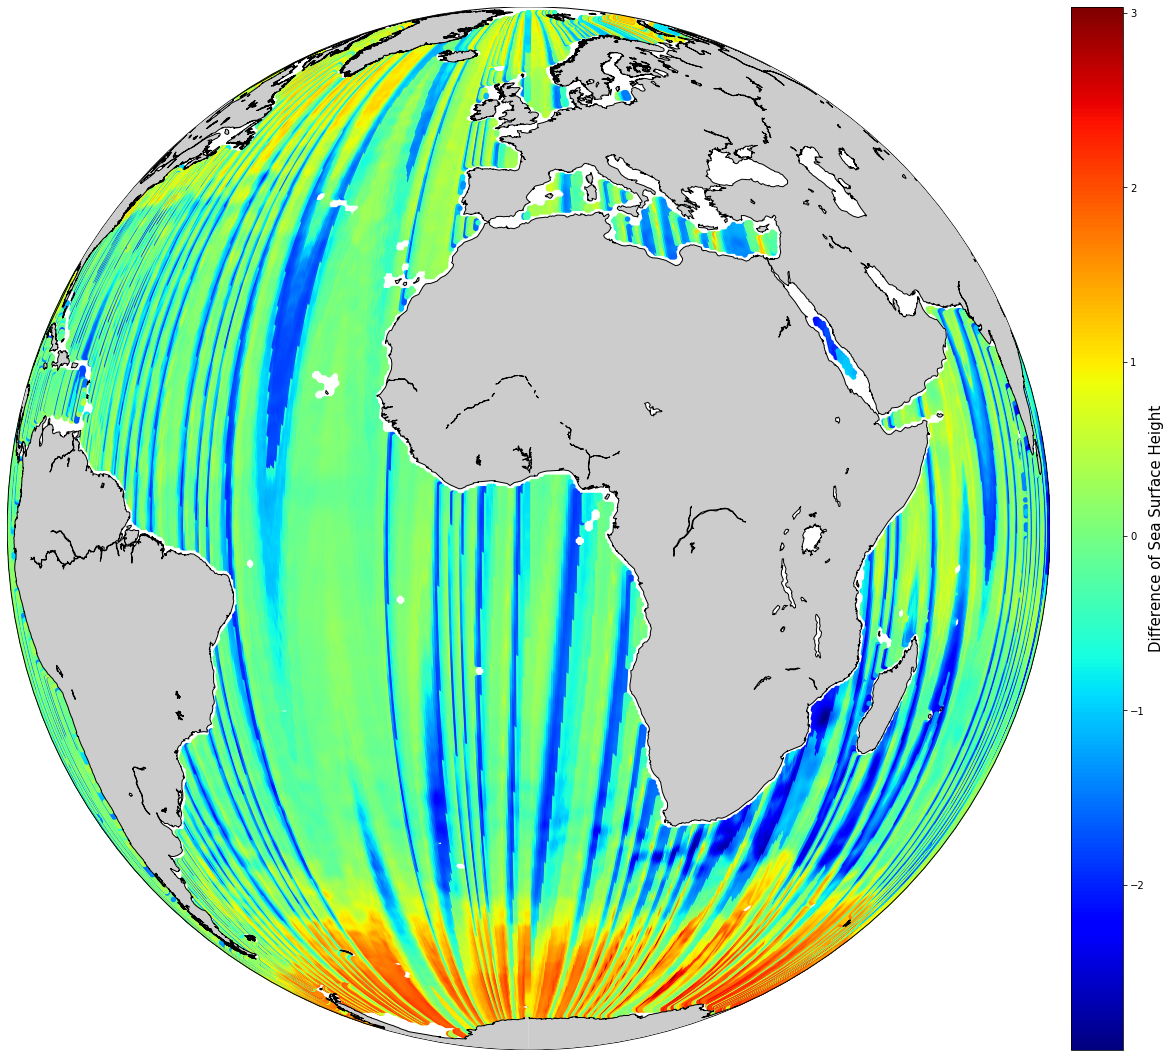

In [46]:
#diff = output.ssh - output2.ssh

diff = zeros(min(len(output.ssh),len(output2.ssh)))
for i in range(len(output.ssh)):
  #for j in range(len(output2.ssh)):
    #if output.lon[i] == output2.lon[j] and output.lat[i] == output2.lat[j]:
      diff[i] = output2.ssh[i] - output.ssh[i]
#for i in range(len(output.time)):
  #if output.time[i] == 734138:
   # fmean_ssh[i] = output.ssh[i] 
  #else:
   # lmean_ssh[i] = output.ssh[i]
plot_im(output.lon,output.lat,diff,30,'Difference of Sea Surface Height (m)')

We can see that the average sea level has been steady near the equator (with small fluctuations), but the sea level has been increasing (about 2 m) near the poles.

In [0]:
%%bigquery --project alert-ground-261008 output
SELECT AVG(ssh) as mean_ssh ,time
FROM bdo2020.bdo2020.2011_2015

GROUP BY time
ORDER BY time

Text(0.5, 0, 'Year')

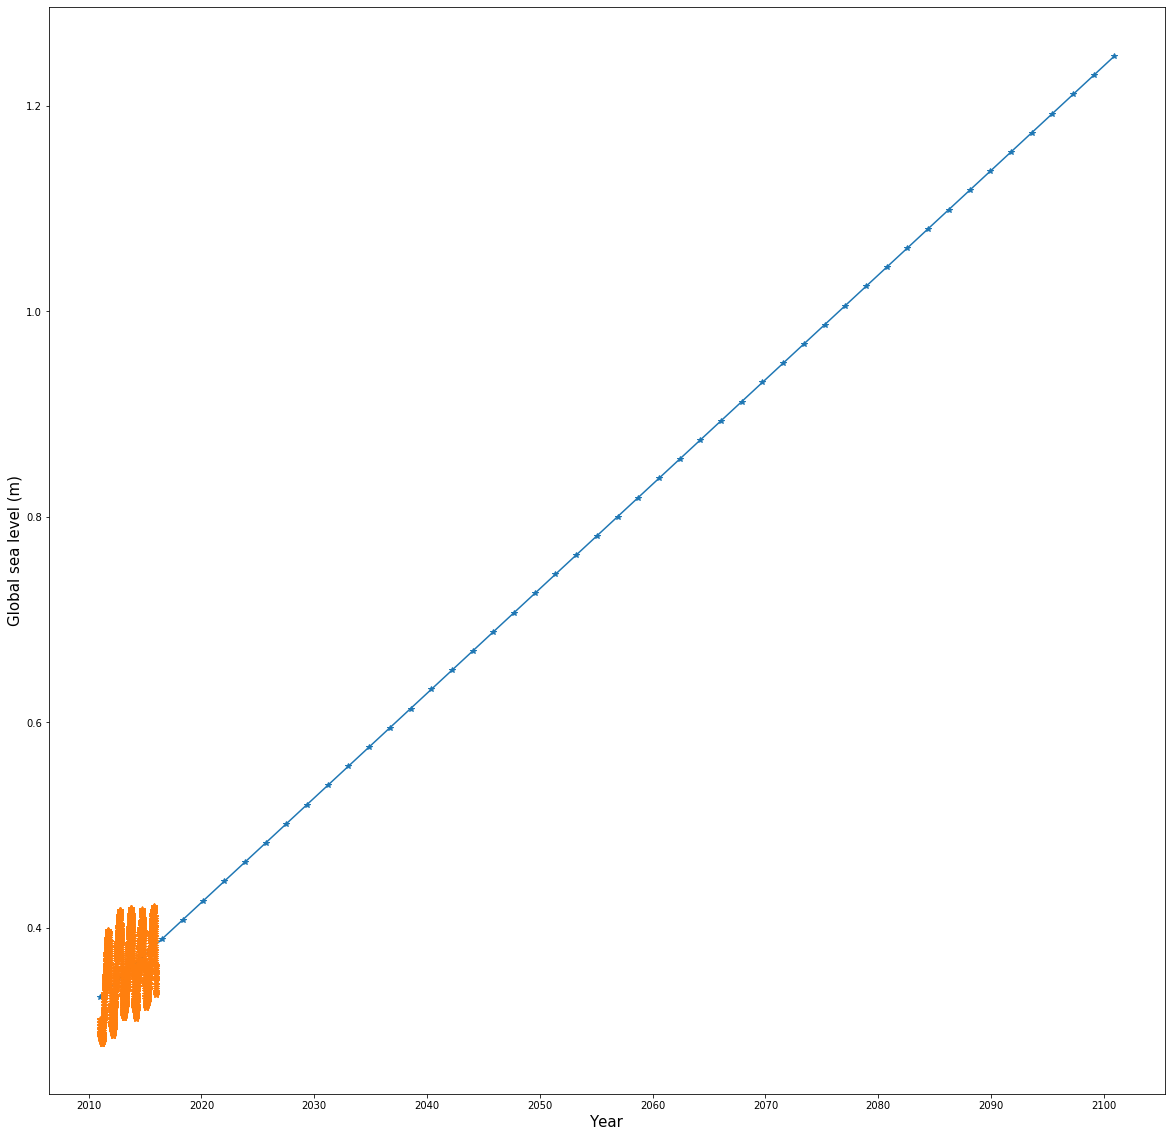

In [0]:
from sklearn import linear_model
import numpy as np
X = output.time
y = output.mean_ssh
X = X[:,np.newaxis]
#y = np.reshape(y,(-1, 1))
reg = linear_model.LinearRegression().fit(X, y)
coef = reg.coef_
intercept = reg.intercept_
X = np.linspace(min(X),min(X)+365*90)
z = coef*X+intercept
plot_ts(X,z,'-*','Mean of SST in the Gulf of Mexico for each day of the year') #I don't think we had to do this
plot_ts(output.time,output.mean_ssh,'-*','Global sea level (m)')
xlabel("Year")

We can see the difference on the ssh of the first day and the last day.But the truth is that there are 536558 records of the first day while 542829 records of the last day.So we show all the data ordered by lon and lat,and we find that the first 536558 data in the second dataset has the same latitude and longitude as that in the first dataset.So we only use the first 536558 data in the second dataset.

After that, we use the linear model to predict the global sea level in the next 100 years.And We can see that in 2100, the sea level would reach 1.25 m (in average).